- In this notebook, I show the performance of PNet and generated the input data of RNet  
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## The PNet Box
- Given an image, this part initially resize it to different scales to bulid an image pyramid, which is the input of the PNet

- Then, it puts the images of the image pramid into PNet to get prediction boxes, converts the boxes into squares and calibrates them according to the offset values.

- After that, it chooses the boxes that might have face (larger than **MIN_FACE_SIZE**) based on the **THRESHOLDS** and deletes the repetitive boxes based on the **NMS_THRESHOLDS**  
- Finally, it returns the bounding box information to show the images.

In [4]:
THRESHOLDS = [0.5, 0.7, 0.8]
NMS_THRESHOLDS = [0.9, 0.7, 0.7]
MIN_FACE_SIZE = 15.0

def pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    pnet.eval()
    width, height = img.size
    min_length = min(height, width)
    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)
    scales = []
    m = min_detection_size / min_face_size
    min_length *= m
    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m * factor ** factor_count)
        min_length *= factor
        factor_count += 1

    # STAGE 1
    bounding_boxes = []
    for s in scales:  # run P-Net on different scales
        boxes = run_first_stage(img, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)
        # bounding_boxes shape:[scales,boxes_num_each_sale,5]
    # [total_boxes_num, 5] is list
    bounding_boxes = [i for i in bounding_boxes if i is not None]

    try:
        _ = bounding_boxes[0]

    except Exception:
        img.show()
    if len(bounding_boxes) == 0:
        return None
    bounding_boxes = np.vstack(bounding_boxes)
    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    return bounding_boxes




In [5]:
def convert_to_square(bboxes):
    """
    Convert bounding boxes to a square form.
    """
    # 将矩形对称扩大为正方形
    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):
    """
        Transform bounding boxes to be more like true bounding boxes.
        'offsets' is one of the outputs of the nets.
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    # w [w_len, 1]
    w = np.expand_dims(w, 1)
    # h [h_len, 1]
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    """ Cut out boxes from the image. """
    num_boxes = len(bounding_boxes)
    # print('bounding_boxes:', bounding_boxes)
    width, height = img.size

    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')

        img_array = np.asarray(img, 'uint8')
        # print('img_array.shape:', img_array.shape)
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        img_box = Image.fromarray(img_box)
        img_box = img_box.resize((size, size), Image.BILINEAR)
        img_box = np.asarray(img_box, 'float32')

        img_boxes[i, :, :, :] = img_normalization(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):
    """
        Crop boxes that are too big and get coordinates
    with respect to cutouts.
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def img_normalization(img):
    """Preprocessing step before feeding the network. """
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    # *0.0078125 i.e. 除以128
    img = (img - 127.5) * 0.0078125
    return img


In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)


class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  
            nn.PReLU(),  
            nn.Conv2d(16, 32, kernel_size=3, stride=1), 
            nn.PReLU() 
        )

        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)        
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        return det, box, landmark

In [7]:
def IoU(box, boxes):
    
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr


In [8]:
def run_first_stage(image, net, scale, threshold):
    
    """ 
        Run P-Net, generate bounding boxes, and do NMS.
    """
    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]
    # offsets shape[4, o_h,o_w]
    offsets = output[1].data.cpu().numpy()
    # boxes
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    # [[x1,y1,x2,y2,score,offsets],[]...]
    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]

def _generate_bboxes(probs, offsets, scale, threshold):
    """
       Generate bounding boxes at places where there is probably a face.
    """
    stride = 2
    cell_size = 12

    # inds = output_feature_map [ :, :]
    inds = np.where(probs > threshold)
    '''
    >>> a =np.array([[1,2,3],[4,5,6]])
    >>> np.where(a>1)
    (array([0, 0, 1, 1, 1]), array([1, 2, 0, 1, 2]))
    '''
    # print('face candidate num'.format(len(inds)))
    if inds[0].size == 0:
        return np.array([])
    # offsets shape[4, o_h,o_w]
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # for i in zip(tx1, ty1, tx2, ty2):
    #     print([i[j] for j in range(4)])

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]
    # print('score:', score)

    # P-Net is applied to scaled images, so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride * inds[1] + 1.0) / scale),
        np.round((stride * inds[0] + 1.0) / scale),
        np.round((stride * inds[1] + 1.0 + cell_size) / scale),
        np.round((stride * inds[0] + 1.0 + cell_size) / scale),
        score, offsets
    ])
    # from
    # [[x1,x1,...]
    #  [y1,y1,...]
    #  [x2,x2,...]
    #  [y2,y2,...]
    # ]to
    # [[x1,y1,x2,y2,score,offsets],[]...]
    # shape[9,boxes_num]
    # print(bounding_boxes.shape)
    # print(bounding_boxes.T.shape)
    return bounding_boxes.T

def nms(boxes, overlap_threshold=0.5, mode='union'):
    """ Pure Python NMS baseline. """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode is 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

## Show the Boxes

#### Set the parameters

In [10]:
landmark_data_dir = '../input/facial-point-detection/Facial_Point_Detection'
landmark_train_txt_path = '../input/facial-point-detection/Facial_Point_Detection/trainImageList.txt'
landmark_eval_txt_path = '../input/facial-point-detection/Facial_Point_Detection/testImageList.txt'
pnet_weight_path='../input/ldmk-pnet-weight/pnet_10000_30 best.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()

P_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): PReLU(num_parameters=1)
  )
  (conv4_1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv4_3): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
def show_boxes(img, bounding_boxes):
    plt.imshow(img)
    for b in bounding_boxes:
        plt.gca().add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=1))
    plt.show()

### Show the PNet performance

#### Train

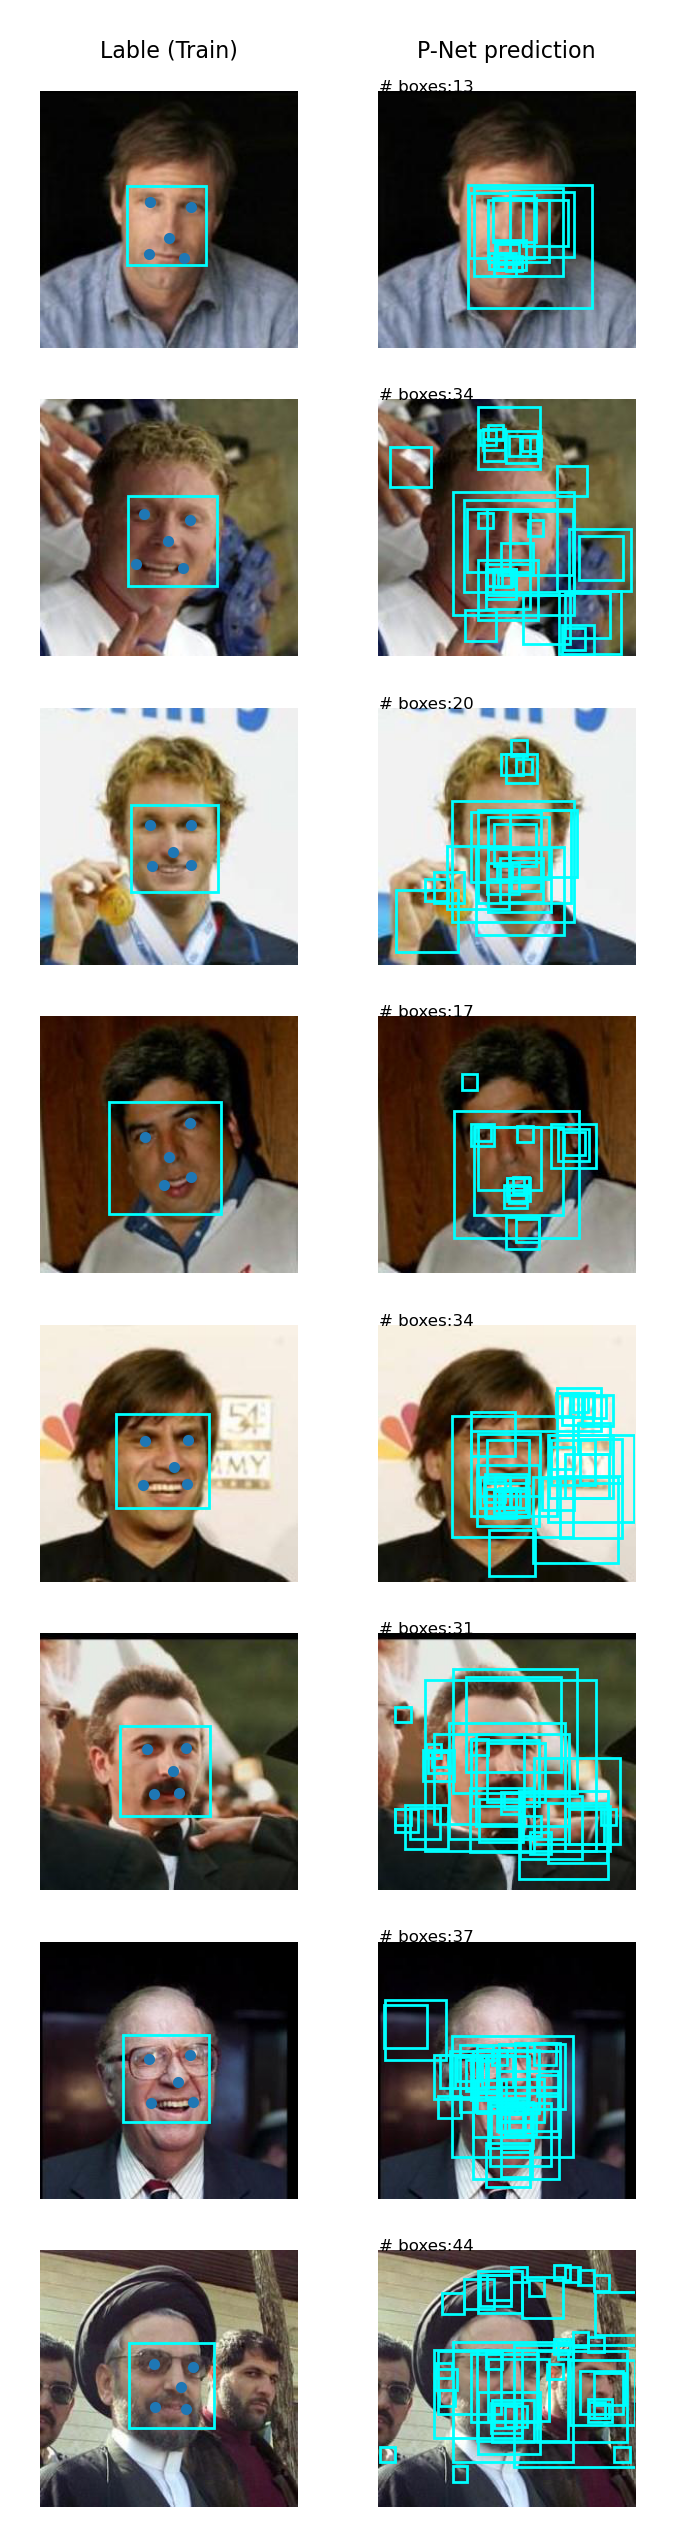

In [13]:
# get 8 fixed images
data_for_demo = landmark_dataset_txt_parser(landmark_train_txt_path, landmark_data_dir,num_data=8)
# box: (x1,x2,y1,y2)
# landmark: (x1,y1,x2,y2,x3,y3...)
# demo and plot
fig, ax = plt.subplots(8,2,dpi = 400, figsize=(2,8))

for i in range(len(data_for_demo)):
    img_pth, gts,p = data_for_demo[i]
    gts=np.array(gts)
    if gts.ndim is 1:
        gts = np.expand_dims(gts, 0)
        gts[:, :] = gts[:, (0, 2, 1, 3)]
    img = Image.open(img_pth)
    bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    
    ax[i,0].imshow(img)
    ax[i,0].scatter([p[j*2] for j in range(5)],[p[j*2+1] for j in range(5)],s=1)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(bounding_boxes)),fontsize=3)
    for b in bounding_boxes:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Train)",fontsize=4)
ax[0][1].set_title("P-Net prediction",fontsize=4)
fig.show()
fig.savefig('Pnet train.png')

#### Eval

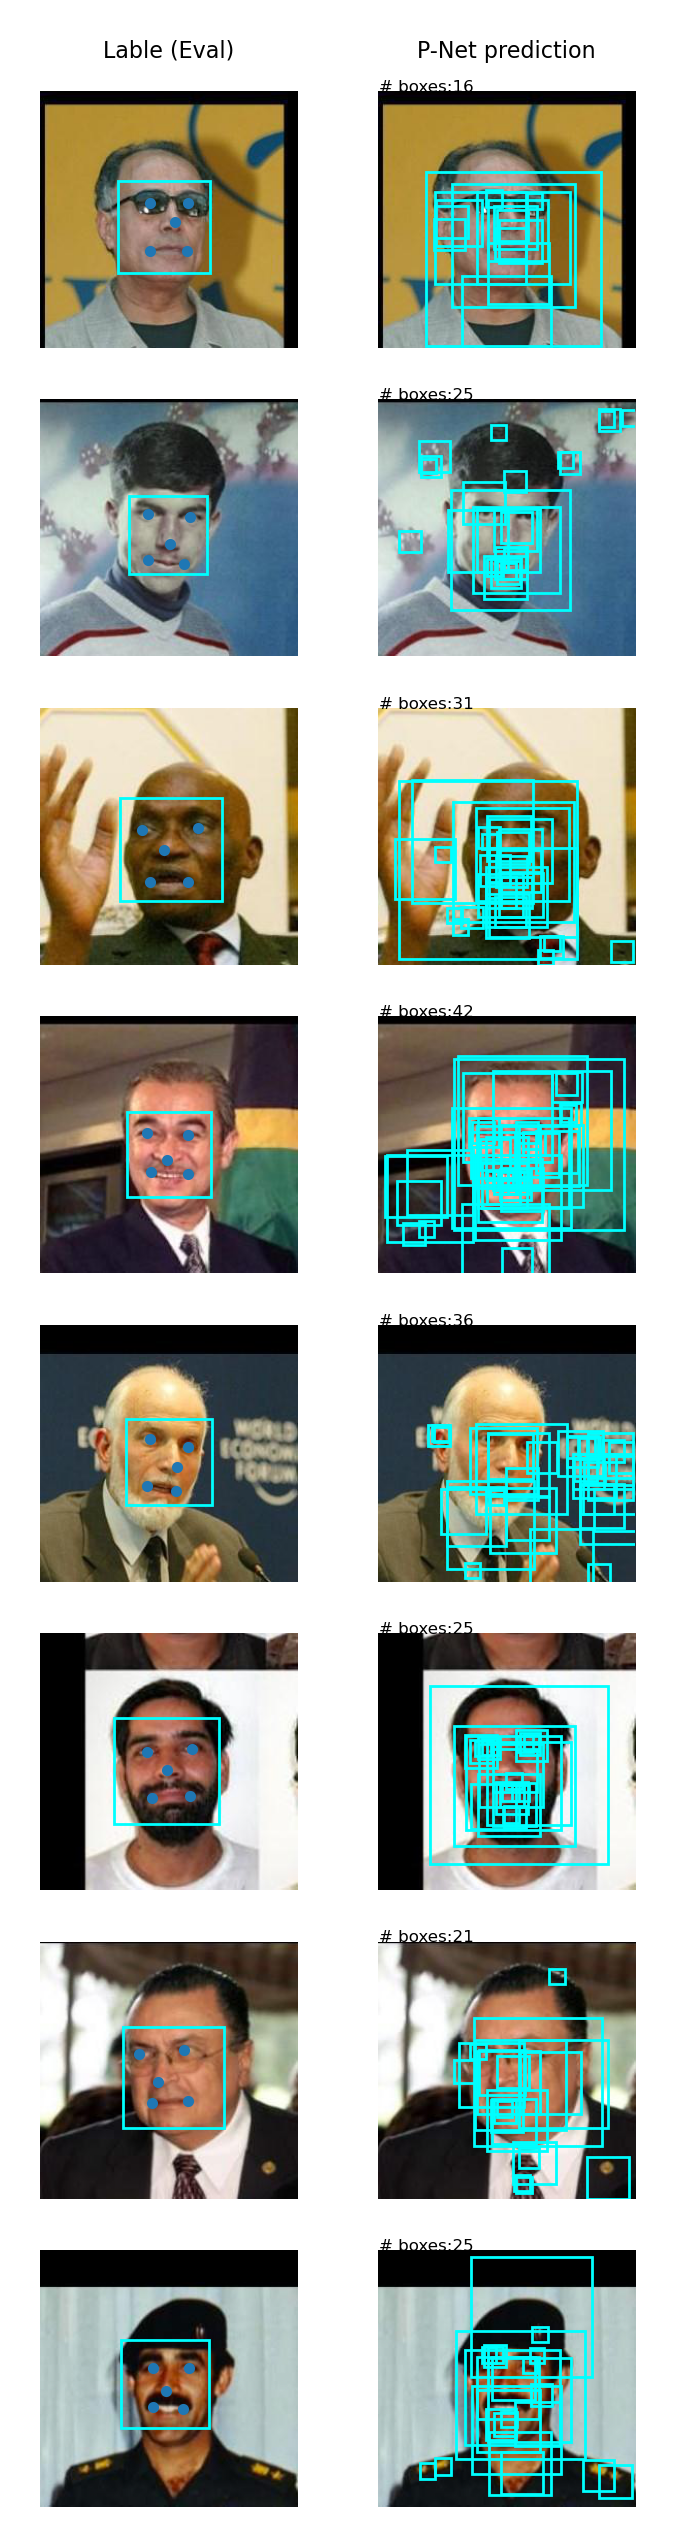

In [14]:
# get 8 fixed images
data_for_demo = landmark_dataset_txt_parser(landmark_eval_txt_path, landmark_data_dir,num_data=8)
# box: (x1,x2,y1,y2)
# landmark: (x1,y1,x2,y2,x3,y3...)
# demo and plot
fig, ax = plt.subplots(8,2,dpi = 400, figsize=(2,8))

for i in range(len(data_for_demo)):
    img_pth, gts,p = data_for_demo[i]
    gts=np.array(gts)
    if gts.ndim is 1:
        gts = np.expand_dims(gts, 0)
        gts[:, :] = gts[:, (0, 2, 1, 3)]
    img = Image.open(img_pth)
    bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    
    ax[i,0].imshow(img)
    ax[i,0].scatter([p[j*2] for j in range(5)],[p[j*2+1] for j in range(5)],s=1)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(bounding_boxes)),fontsize=3)
    for b in bounding_boxes:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Eval)",fontsize=4)
ax[0][1].set_title("P-Net prediction",fontsize=4)
fig.show()
fig.savefig('Pnet eval.png')

## Generate the Input Data for RNet  
- In this part, it puts the images into the PNet to get the prediction boxes and save the crop information and the name of the coresponding images in a txt file.

- The output txt file should have lines in this format:
      image_path *gt_x1, gt_y1, gt_x2, gt_y2* Lx1,Ly1,Lx2,Ly2,Lx3,Ly4,Lx5,Ly5*label cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, cr_x1, cr_y1, cr_x2, cr_y2 * \n
  Here is an example:
      ../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Ali_Khamenei_0001.jpg*71,85,178,192*107,111,150,107,125,136,113,152,148,151*pf,96,98,185,186+pf,74,93,195,215

In [15]:
landmark_train=landmark_dataset_txt_parser(landmark_train_txt_path, landmark_data_dir,num_data=train_num)
landmark_eval=landmark_dataset_txt_parser(landmark_eval_txt_path, landmark_data_dir,num_data=eval_num)

In [16]:
def get_size_faces_ldmk(img_faces, index):
    def load_img(img_path):
        try:
            img = Image.open(img_path)
            img = img.convert('RGB')
        except Exception:
            print('*** warning loading fail!')
            return
        return img

    img_face = img_faces[index]
    img_path = img_face[0]
    faces = np.array(img_face[1])      
    faces = np.expand_dims(faces, 0)
    faces[:, :] = faces[:, (0, 2, 1, 3)]
    ldmk = None if len(img_face) < 3 else [int(i) for i in img_face[2]]
    img=load_img(img_path)
    return img, faces,ldmk

def get_crop_img_label_box(img ,faces,pnet):
    iou_th = {'n': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}
    bounding_boxes = pnet_boxes(img, pnet)
    if bounding_boxes is None:
        return None, None, None
    
    crop_box = None
    closet_face = None
    label_boxes=[]
    width,height=img.size
    
    for id, box in enumerate(bounding_boxes, start=1):
        box = [min(max(0, int(box[i])), width if i % 2 == 0 else height) for i in range(4)]
        if box[2] - box[0] < 24: continue
        iou = IoU(box, faces)
        iou_max = iou.max()
        iou_index = iou.argmax()
        closet_face = faces[iou_index]             
                
        for temp_label in iou_th:
            if iou_max < iou_th[temp_label][0] or iou_max > iou_th[temp_label][1]:
                continue
            else:
                label = temp_label
                crop_box = box
                crop_box=[str(l) for l in crop_box]
                label_boxes.append([label,crop_box])

    return label_boxes

In [36]:
rnet_train_data=open('ldmk_rnet_train_data.txt', 'w')
print('Train Begin')
for index in range(len(landmark_train)):
    
    if index%500==0:
        print(index)
    img, faces,ldmk=get_size_faces_ldmk(landmark_train, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet)
    img_path=landmark_train[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1]) for w in label_boxes])
        faces=','.join([str(i) for i in faces[0]])
        if ldmk is not None:
            ldmk=','.join([str(i) for i in ldmk])
        else:
            print(img_path,'no ldmk')
        rnet_train_data.write(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
        if index <=3:
            print(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
    except:
        print('Wrong:',label_boxes)
rnet_train_data.close()   
print('Train End')


rnet_eval_data=open('ldmk_rnet_eval_data.txt', 'w')
print('Eval Begin')
for index in range(len(landmark_eval)):
    if index%500==0:
        print(index)
    img, faces,ldmk=get_size_faces_ldmk(landmark_eval, index)
    label_boxes=get_crop_img_label_box(img ,faces,pnet)
    img_path=landmark_eval[index][0]
    try:
        boxes='+'.join([w[0]+','+','.join(w[1]) for w in label_boxes])
        faces=','.join([str(i) for i in faces[0]])
        if ldmk is not None:
            ldmk=','.join([str(i) for i in ldmk])
        else:
            print(img_path,'no ldmk')
        rnet_eval_data.write(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
        if index <=3:
            print(img_path+'*'+faces+'*'+ldmk+'*'+boxes+'\n')
    except:
        print('Wrong:',label_boxes)
rnet_train_data.close()   
print('Eval End')



Eval Begin
0
../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Abbas_Kiarostami_0001.jpg*75,87,165,177*106,108,143,108,131,127,106,155,142,155*pf,71,90,191,210+pf,96,98,186,187+n,106,147,166,207+pf,106,106,165,165+n,55,111,87,142+n,112,111,154,153+n,113,133,143,163+pf,55,98,143,187+n,56,106,100,150+n,117,125,159,167+n,115,115,145,145+n,81,179,168,250+n,54,124,84,154+n,46,78,216,248

../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Abdel_Madi_Shabneh_0001.jpg*86,93,162,169*104,110,145,114,126,139,104,155,139,159*pf,92,104,176,188+pf,96,106,157,167+pf,70,88,186,204+n,113,143,144,174+n,82,80,123,121+n,119,109,149,139+n,102,152,144,194+n,39,40,69,70+n,109,154,138,183

../input/facial-point-detection/Facial_Point_Detection/lfw_5590/Abdoulaye_Wade_0001.jpg*77,87,177,187*98,118,152,116,120,137,106,168,143,169*p,95,97,185,187+n,117,160,160,203+n,104,154,164,213+n,114,144,144,174+p,72,91,190,208+n,113,183,143,213+n,117,117,159,159+n,118,138,158,179+n,107,136,193,222